In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 살펴보기 및 전처리

In [11]:
data_dir = os.getenv('HOME')+'/aiffel/exploration'


train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') 


train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

In [12]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
#전처리를 위한 데이터 결합
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [14]:
#date전처리
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [15]:
#target 열 삭제
y = train['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# id 열 삭제

sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [17]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

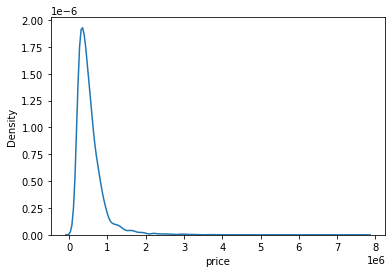

In [18]:
sns.kdeplot(y)
plt.show()

In [19]:
#한쪽으로 치우쳐있으니 로그변환
y = np.log1p(y)


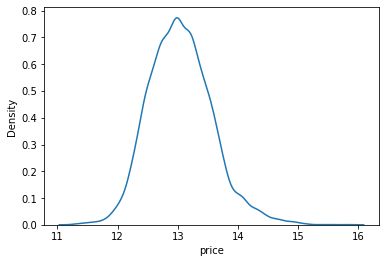

In [20]:
sns.kdeplot(y)
plt.show()

In [21]:
data.info() #feature 타입 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

<AxesSubplot:>

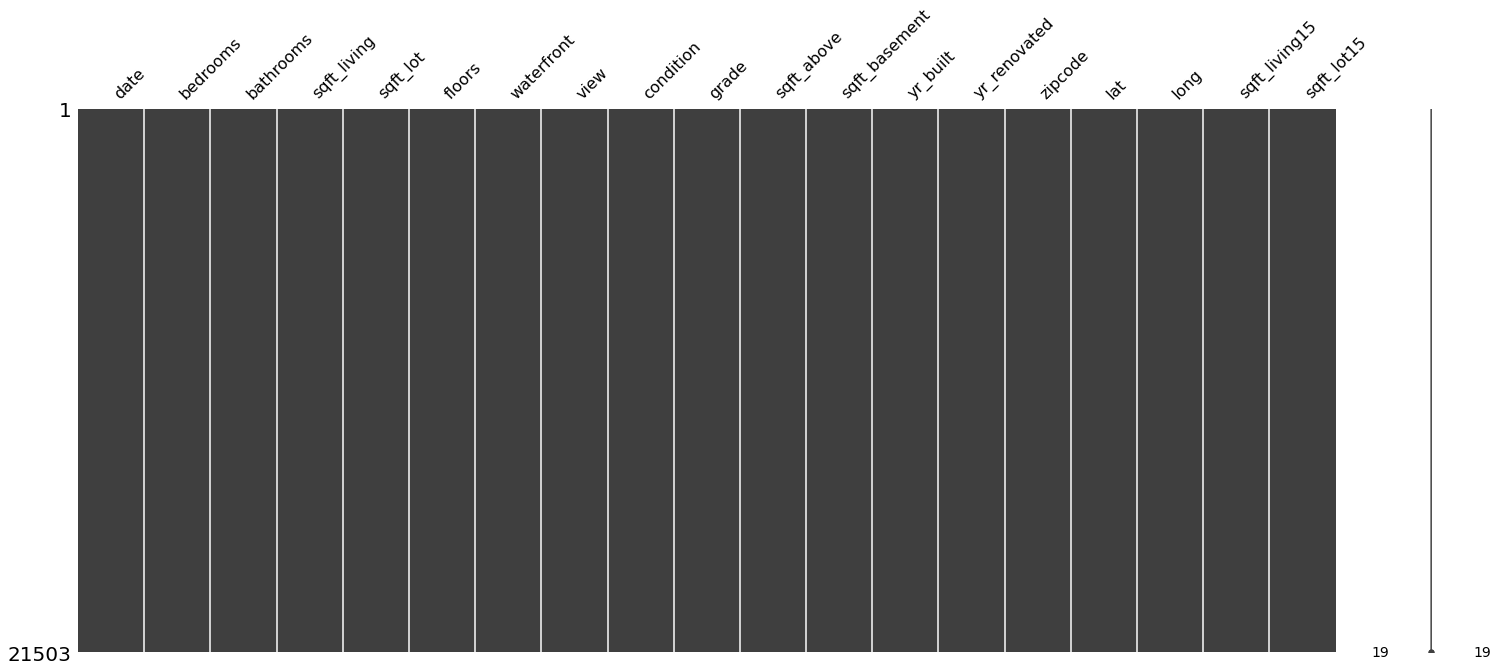

In [22]:
#결측치 확인
msno.matrix(data)

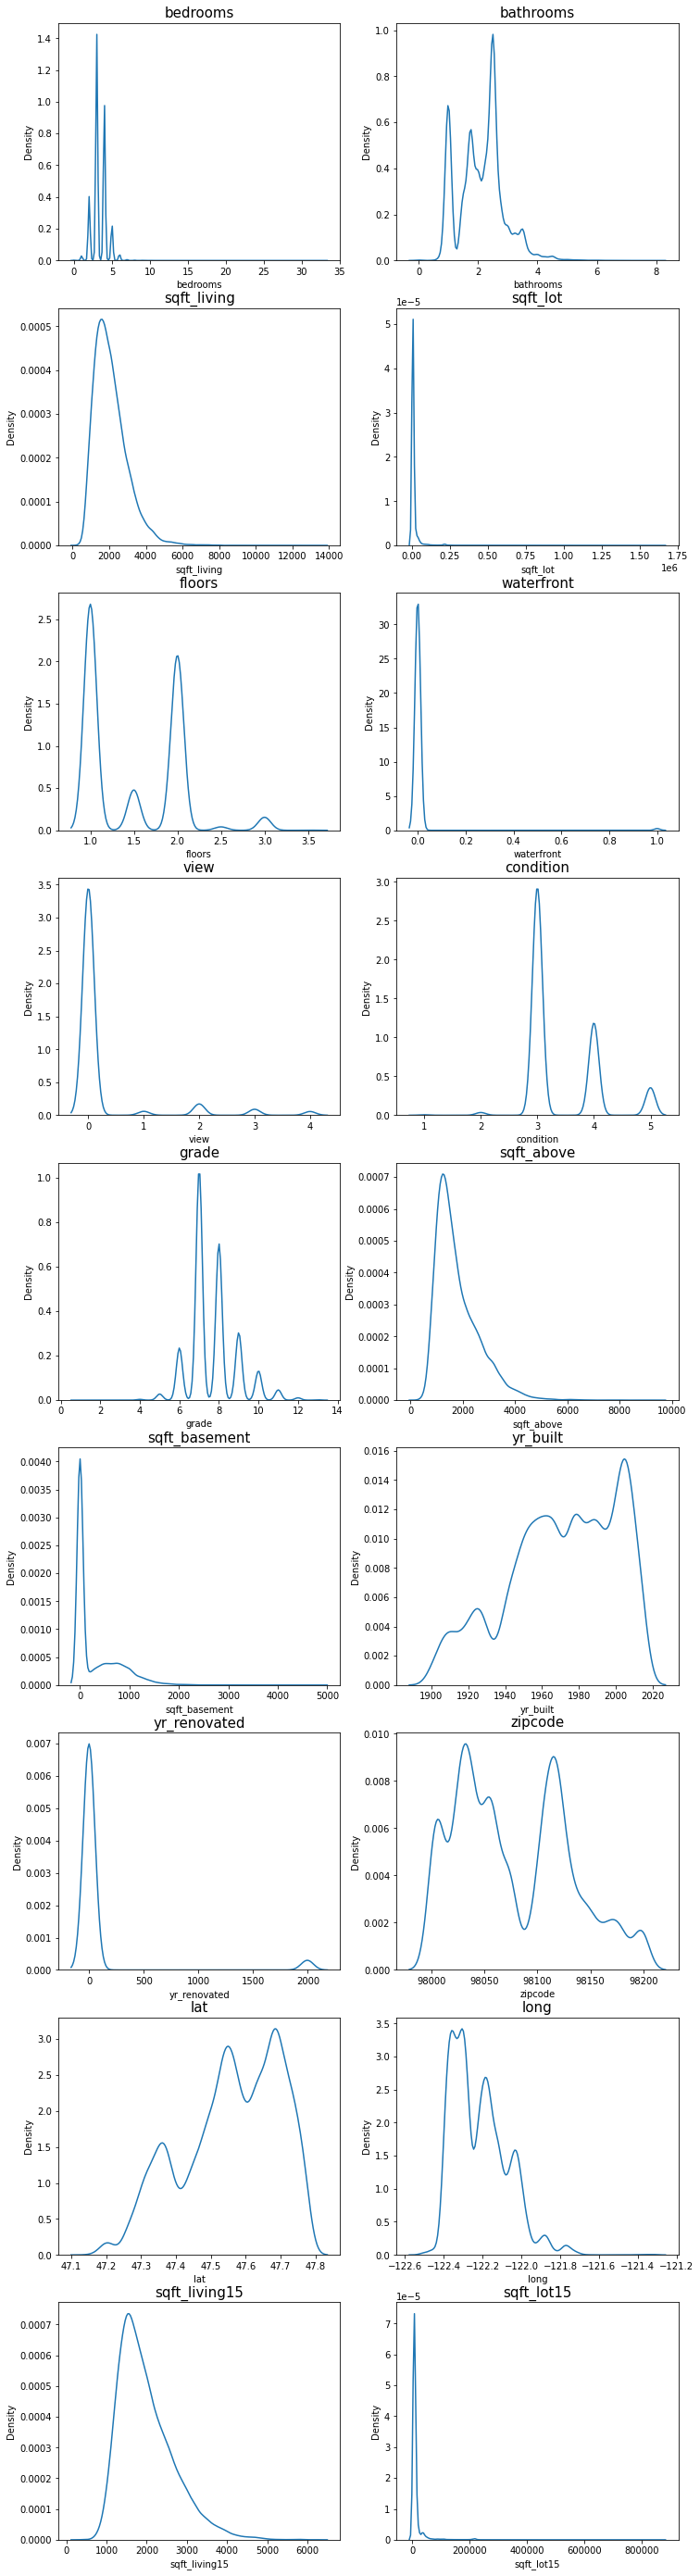

In [23]:
# 변수 분포 시각화

fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [24]:
#왜도 확인
from scipy.stats import skew, kurtosis
columns = data.columns
skew = {}
for col in columns:
    skew[col] = data[col].skew()
dict(sorted(skew.items(), key=lambda x : x[1]))

{'lat': -0.48682988646238357,
 'yr_built': -0.4717295219052844,
 'zipcode': 0.40740551592074603,
 'bathrooms': 0.5106526932083862,
 'floors': 0.6134987575975112,
 'date': 0.7643802765295065,
 'grade': 0.7705299891915451,
 'long': 0.8840484561667199,
 'condition': 1.0366466128611789,
 'sqft_living15': 1.1065938309038392,
 'sqft_above': 1.4460080680592546,
 'sqft_living': 1.4714137250528125,
 'sqft_basement': 1.5763445992828624,
 'bedrooms': 1.9833848228737991,
 'view': 3.3920639617241384,
 'yr_renovated': 4.539105326160543,
 'sqft_lot15': 9.509189855329153,
 'waterfront': 11.355433646283545,
 'sqft_lot': 13.063414417656206}

In [25]:
# 분포가 치어친 feature들을 log-scaling 해보자(왜도가 1 이상))
skew_columns = ['sqft_lot', 'waterfront', 'sqft_lot15', 'yr_renovated', 'view', 'bedrooms',
               'sqft_basement','sqft_living','sqft_above','sqft_living15','condition']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

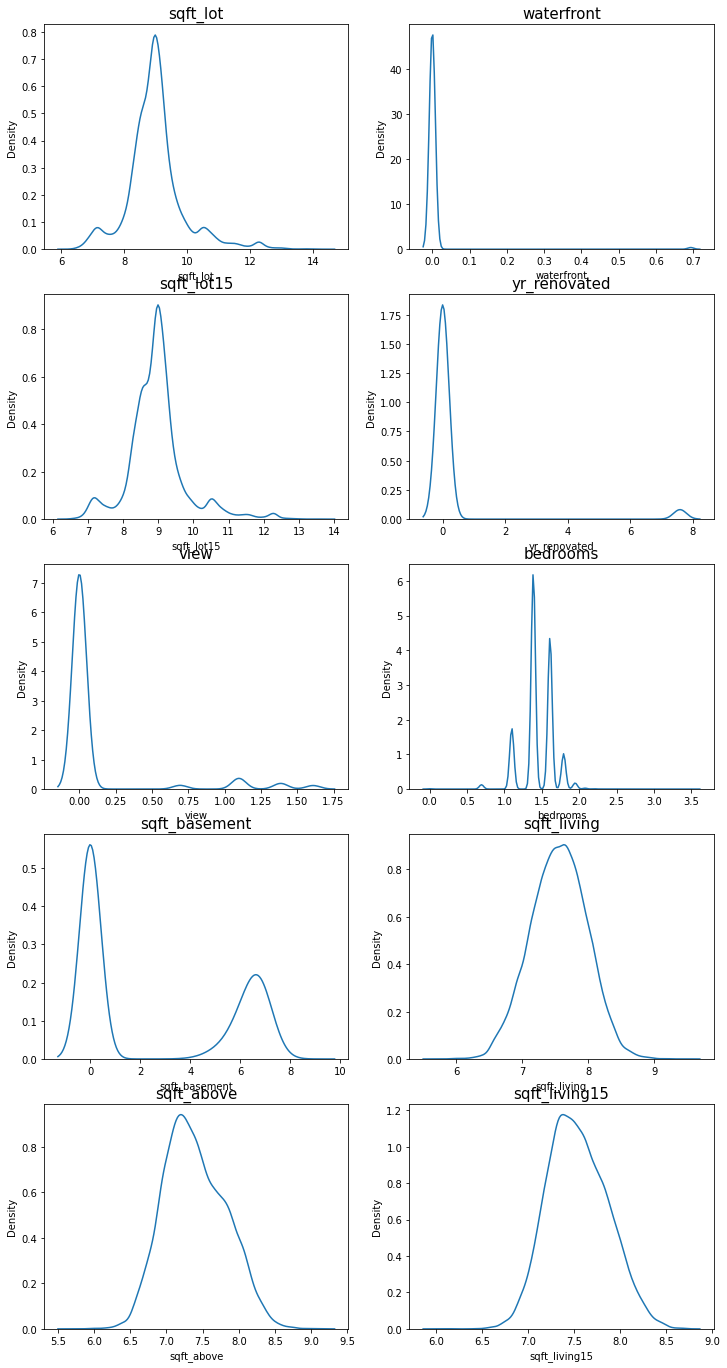

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(12, 24))

count = 0
for row in range(5):
    for col in range(2):
        if count == 10:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [27]:
#종속변수와 독립변수 상관관계도 확인해보자, 아까 price를 지웠었는데, 잠깐 넣어보자
train['price'] = y
corr_df = train.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_price = corr_df['price']
corr_price 

id               0.04
price            1.00
bedrooms         0.36
bathrooms        0.55
sqft_living      0.70
sqft_lot         0.11
floors           0.32
waterfront       0.17
view             0.35
condition        0.04
grade            0.71
sqft_above       0.61
sqft_basement    0.31
yr_built         0.08
yr_renovated     0.13
zipcode         -0.04
lat              0.44
long             0.05
sqft_living15    0.62
sqft_lot15       0.10
Name: price, dtype: float64

In [28]:
df = pd.DataFrame(corr_price)
df

,price
id,0.04
price,1.00
bedrooms,0.36
bathrooms,0.55
sqft_living,0.70
sqft_lot,0.11
floors,0.32
waterfront,0.17
view,0.35
condition,0.04


In [29]:
#전처리가 끝났으니 다시 분리
train =  data.iloc[:train_len, :]

test =data.iloc[train_len:, :]


## 평가함수 및 모델 함수 선언

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
#rmse계산함수
#이때, y_test, y_pred는 로그변환 되어있기 때문에 expm1을 통해 다시 변환해줘야함
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))



In [32]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



In [33]:
random_state=631       

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)


models = [gboost, xgboost, lightgbm]



In [34]:

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__ #모델 이름 얻기
        
        #train , validation set으로 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #rmse값 df에 넣기
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


In [35]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,135887.169899
LGBMRegressor,115830.650883
XGBRegressor,109785.510014


## 하이퍼 파라미터 튜닝

In [36]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_depth': randint(low=1, high=8), } 



In [37]:
def my_RandomSearch(model, train, y,hyperparam, verbose=2, n_jobs=5):
    
    
            
    
    # GridSearchCV 모델로 초기화
    random_model = RandomizedSearchCV(model, hyperparam,random_state=random_state,
                                    scoring='neg_mean_squared_error',n_iter=10,
                                    cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    random_model.fit(train, y)

    # 결과값 저장
    print('estimator:', random_model.best_estimator_.get_params()['n_estimators'])
    print('max_depth:', random_model.best_estimator_.get_params()['max_depth'])
    
    
   



In [38]:
def AveragingBlending(models, trian, y):
    
    for model in models:
        model_name = model.__class__.__name__ #모델 이름 얻기
        
        #train , validation set으로 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        
    
    
    predictions = np.column_stack([
        model.predict(X_test) for model in models
    ])
    
    print(f"result_rmse: {rmse(y_test, np.mean(predictions, axis=1))}")
    
    return np.mean(predictions, axis=1)


        
    

In [39]:
xgboost = XGBRegressor(random_state=random_state)
my_RandomSearch(xgboost, train,y,param_distribs,verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

estimator: 178
max_depth: 3


In [40]:
gboost = GradientBoostingRegressor(random_state=random_state)
my_RandomSearch(gboost, train,y,param_distribs,verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
estimator: 87
max_depth: 7


In [41]:
lightgbm = LGBMRegressor(random_state=random_state)
my_RandomSearch(lightgbm, train,y,param_distribs,verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
estimator: 87
max_depth: 7


## 하이퍼 파라미터를 적용하여 모델 평가

In [42]:
gboost = GradientBoostingRegressor(random_state=random_state,n_estimators=132, max_depth=6)
xgboost = XGBRegressor(random_state=random_state,n_estimators=140,max_depth=4)
lightgbm = LGBMRegressor(random_state=random_state,n_estimators=132,max_depth=6)


models = [gboost, xgboost, lightgbm]


In [43]:
get_scores(models, train, y)

,RMSE
LGBMRegressor,113692.889116
GradientBoostingRegressor,109033.480814
XGBRegressor,107450.880476


## 블렌딩을 해보면?

In [44]:
y_pred= AveragingBlending(models, train, y)
    
# 이 결과는 valiadtion set 결과

result_rmse: 105264.09163136751


In [45]:
# test셋에 적용하여 y_pred를 나타내보자.

for model in models:
    model_name = model.__class__.__name__ #모델 이름 얻기
    model.fit(train, y) # 모델 학습
        
   
predictions = np.column_stack([
    model.predict(test) for model in models
])
    
    
    
y_pred = np.mean(predictions, axis=1)
y_pred.shape

(6468,)

In [46]:
# 원래 스케일로 변환
y_pred = np.expm1(y_pred)

## 파일 저장

In [47]:
data_dir = os.getenv('HOME')+'/aiffel/exploration'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [48]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.265838e+05
1,15036,4.612407e+05
2,15037,1.424479e+06
3,15038,3.085612e+05
4,15039,3.344844e+05


In [49]:
my_submission_path = join(data_dir, 'final_submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/exploration/final_submission.csv


## 의문점: feature들을 log 변환 하지 않는다면 성능이 어떻게 변할까?

In [72]:
#다시 데이터 로드 후 price 삭제
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
y = train['price']
del train['price']
del train['id']
del test['id']

#date전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

train


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [73]:
y = np.log1p(y)


In [74]:
get_scores(models, train, y) 

,RMSE
LGBMRegressor,113693.775554
GradientBoostingRegressor,108849.923634
XGBRegressor,107394.841768


아직 블렌딩 하지는 않았지만, feature들을 log변환 하지 않을때가 했을때보다 소폭 성능이 좋게 나왔다. 
이번에는 블렌딩을 해보자.

In [75]:
y_pred= AveragingBlending(models, train, y)

result_rmse: 105141.22718515502


블렌딩을 했더니 rmse가 100점정도 낮아졌다. 


In [77]:
#test set에 적용해보자.
for model in models:
    model_name = model.__class__.__name__ #모델 이름 얻기
    model.fit(train, y) # 모델 학습
        
   
predictions = np.column_stack([
    model.predict(test) for model in models
])
    
    
    
y_pred = np.mean(predictions, axis=1)
y_pred = np.expm1(y_pred)
y_pred.shape

(6468,)

In [78]:
#파일 저장
data_dir = os.getenv('HOME')+'/aiffel/exploration'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})
my_submission_path = join(data_dir, 'realfinal_submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)


/aiffel/aiffel/exploration/realfinal_submission.csv


## PCA

In [80]:
#아까 feature의 상관계수를 확인해볼때, target와 상관계수가 매우 낮은 feature들도 있었으니, pca등 차원축소를 통해 overfitting을 방지해서 다시 test해보자

from sklearn.preprocessing import StandardScaler
#pca 전에 표준화를 한다. pca 전에 표준화를 하지 않으면 분산을 유지하는 영향력이 달라질 수 있다.




scaler = StandardScaler()    
scaler.fit(train)
train_feature_scaled = scaler.transform(train)
test_feature_scaled = scaler.transform(test)

train = pd.DataFrame(train_feature_scaled,index=train.index, columns=train.columns)
test = pd.DataFrame(test_feature_scaled, index=test.index, columns=test.columns)

train.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,-0.645099,-0.408931,-1.452865,-0.980140,-0.226394,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.738427,-0.657286,-0.547510,-0.209296,1.875717,-0.358430,-0.306626,-0.944060,-0.258655
1,1.433970,-1.516730,-1.452865,-1.424775,-0.124309,-0.924917,-0.084662,-0.306875,-0.62902,-1.407676,-1.231387,-0.657286,-1.295641,-0.209296,-0.938751,1.282425,-0.136763,1.051794,-0.171690
2,1.433970,-0.408931,-0.149923,-0.437901,-0.169367,-0.924917,-0.084662,-0.306875,-0.62902,0.287579,-0.137257,-0.657286,0.540680,-0.209296,-0.075648,0.405903,1.193836,-0.278776,-0.191845
3,-0.735493,-0.408931,0.175813,-0.399945,-0.198960,0.932080,-0.084662,-0.306875,-0.62902,-0.560048,-0.095175,-0.657286,0.812727,-0.209296,-1.407829,-1.816888,-0.802062,0.354691,-0.216507
4,1.411372,-0.408931,-0.801394,-1.110277,-0.131091,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.882708,-0.657286,-0.275463,-0.209296,2.250979,-1.094536,-0.717130,-0.495716,-0.112235


In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=19) #일단 모든 feature의 수를 다 넣는다.
pca.fit(train_feature_scaled)
 
train_feature_reduced = pca.transform(train_feature_scaled)
test_feature_reduced = pca.transform(test_feature_scaled)

In [82]:
#train_feature_reduced만 df로 확인
pca_df = pd.DataFrame(train_feature_reduced, train.index,
                      columns=[f"pca{num+1}" for num in range(train.shape[1])])
pca_df.head()


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19
0,-2.653712,-0.019229,-0.305297,0.725353,0.362057,-0.325165,-0.270524,0.623039,-0.320591,-0.472125,1.157843,0.022505,-0.943389,-0.369883,0.176195,0.210593,-0.508676,-0.065399,7.090337e-16
1,-2.612017,-0.651289,0.364388,0.344434,-0.051945,1.083338,0.318221,-2.384421,-0.482335,-0.687997,0.468737,0.290695,0.972064,0.585299,-0.465971,0.437514,1.412594,-0.187743,5.790532e-18
2,-0.321684,-1.165441,-0.205671,0.054605,-0.235877,1.277718,0.357280,-1.218993,-0.504171,-0.052877,0.192183,0.053195,-0.610092,-0.682202,0.364328,-0.314700,-0.356958,-0.310617,2.446730e-16
3,0.112695,-1.641348,-0.651296,-0.053802,-1.143446,-0.678861,-0.021176,1.467093,0.077194,-0.418063,-0.200597,0.392706,1.176825,0.391725,-0.379731,0.180081,0.830611,0.165805,-5.545618e-16
4,-2.423117,-0.026740,-0.261248,0.893679,-0.004484,1.685053,0.242444,1.071215,0.203181,-0.597121,0.888187,0.378745,-1.150872,-0.637629,0.009407,0.205047,0.087756,-0.435852,2.258553e-16


In [83]:
#각 주성분의 기여율을 구해보자.
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'고유값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(train.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고유값,기여율,누적기여율
pca1,5.268308e+00,2.772609e-01,0.277261
pca2,2.199422e+00,1.157514e-01,0.393012
pca3,1.841956e+00,9.693859e-02,0.489951
pca4,1.377971e+00,7.251996e-02,0.562471
pca5,1.201167e+00,6.321511e-02,0.625686
pca6,1.015305e+00,5.343357e-02,0.679120
pca7,9.886073e-01,5.202850e-02,0.731148
pca8,8.688570e-01,4.572627e-02,0.776874
pca9,8.314515e-01,4.375769e-02,0.820632
pca10,6.532503e-01,3.437931e-02,0.855011


In [84]:
#누적 기여율이 80%가 넘어가는 주성분 9개만 사용하여 pca를 진행해보자.
pca = PCA(n_components=9) #일단 모든 feature의 수를 다 넣는다.
pca.fit(train_feature_scaled)
 
train_feature_reduced = pca.transform(train_feature_scaled)
test_feature_reduced = pca.transform(test_feature_scaled)



result = pd.DataFrame({'고유값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(train_feature_reduced.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고유값,기여율,누적기여율
pca1,5.268308,0.277261,0.277261
pca2,2.199422,0.115751,0.393012
pca3,1.841956,0.096939,0.489951
pca4,1.377971,0.072520,0.562471
pca5,1.201167,0.063215,0.625686
pca6,1.015305,0.053434,0.679120
pca7,0.988607,0.052029,0.731148
pca8,0.868857,0.045726,0.776874
pca9,0.831451,0.043758,0.820632


## 차원축소가 끝난 결과를 회귀모델에 넣어보기

In [85]:
get_scores(models, train_feature_reduced, y) 

,RMSE
XGBRegressor,184387.609854
LGBMRegressor,180643.912608
GradientBoostingRegressor,177965.423755


모델이 성능이 굉장히 안좋아졌다.... 
이유가 뭘까?  
내 생각에는 
data의 구조가 바뀌었는데, 하이퍼파라미터 튜닝을 따로 하지 않고 기존의 하이퍼 파라미터 튜닝을 한 모델을 그대로 사용해서 인것 같다.

일단 blending을 해보자.


In [60]:
y_pred= AveragingBlending(models, train_feature_reduced, y)

result_rmse: 105828.62028561167


블렌딩한 수치는 엄청 낮아졌다. 한번 test set으로 확인해보자

In [87]:
#test set에 적용해보자.
for model in models:
    model_name = model.__class__.__name__ #모델 이름 얻기
    model.fit(train_feature_reduced, y) # 모델 학습
        
   
predictions = np.column_stack([
    model.predict(test_feature_reduced) for model in models
])
    
    
    
y_pred = np.mean(predictions, axis=1)
y_pred = np.expm1(y_pred)
y_pred.shape

(6468,)

In [88]:
#파일 저장
data_dir = os.getenv('HOME')+'/aiffel/exploration'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})
my_submission_path = join(data_dir, 'zzinrealfinal_submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)


/aiffel/aiffel/exploration/zzinrealfinal_submission.csv


## 회고

이번 노드가 데이터 EDA에 제일 많이 배운 시간이 아닌가 싶다. feature들을 이리저리 다뤄보면서 제일 높은 성능이 무엇일까 고민하면서 여러 방법을 써본게 전처리 공부에 큰 도움이 된 것 같다.
아쉬운점은 최종 score가 115,000점으로 기준 점수인 111,000점을 달성하지 못했다는 점이 굉장히 아쉽다.
이번 노드를 진행하면서 든 궁금점은 feature들의 정규성을 위해 표준화라는 방법이 있는데 왜 log변환을 해야하는지에 대한 것과, 실제로 코드를 돌려본 결과, 데이터의 정규성이 만족되지 않아도 결과가 비슷한데, 데이터의 정규성이 왜 중요한지가 궁금했다. 
이번 노드를 이미 진행한 분들의 다양한 커널을 확인해봤는데, 모델을 구성하는것보다 데이터 전처리와 feature들의 의미를 파악하는것이 매우 중요한것 같다. 데이터를 받았을때, 그냥 돌려보고 성능을 올리기에만 급급했지, feature의 의미를 제대로 생각해본적이 없었는데, 이런 캐글이나 데이콘 등의 실습을 진행할때, 데이터의 의미를 제대로 파악하는게 가장 중요한 것 같다는 생각이 들었다.
